In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def get_normalize(features: torch.Tensor):
    shape = (0, 1, 2)
    means = features.data.mean(axis=shape)
    stds = features.data.std(axis=shape)
    return means, stds

In [3]:
def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [4]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple([float, float]):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [5]:
def create_simple_conv_cifar():

    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout2d(p=0.2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout2d(p=0.2),

        nn.Flatten(),
        nn.Linear(64 * 8 * 8, 512),
        nn.ReLU(),

        nn.Linear(512, 10)
    )
    
    return model

In [33]:
def create_advanced_conv_cifar():

    model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Dropout2d(p=0.2),
        
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
        nn.BatchNorm2d(512),
        nn.ReLU(),
        
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Dropout2d(p=0.2),
        
        nn.Flatten(),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.3),
        nn.ReLU(),
        nn.Linear(256, 10)
    )
    
    return model

In [5]:
from IPython.display import clear_output

def plot_stats(
    train_loss: list([float]),
    valid_loss: list([float]),
    train_accuracy: list([float]),
    valid_accuracy: list([float]),
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [6]:
def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        if valid_accuracy >= 0.9:
            break

        scheduler.step()

In [7]:
@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    preds = []
    
    for x, y in loader:
        x,y = x.to(device), y.to(device)
        
        output = model(x)
        
        pred = torch.argmax(output, 1)
        
        preds.append(pred)
        
    return torch.cat(preds)

In [8]:
train_data = CIFAR10("../datasets/cifar10", train=True, download=True, transform=T.ToTensor())
test_data = CIFAR10("../datasets/cifar10", train=False, download=True, transform=T.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../datasets/cifar10/cifar-10-python.tar.gz to ../datasets/cifar10
Files already downloaded and verified


In [10]:
means = (train_data.data / 255).mean(axis=(0,1,2))

means

array([0.49139968, 0.48215841, 0.44653091])

In [11]:
stds = (train_data.data / 255).std(axis=(0, 1, 2))

stds

array([0.24703223, 0.24348513, 0.26158784])

In [11]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

In [12]:
loss_fn = nn.CrossEntropyLoss()

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
Tesla T4


In [15]:
model = create_simple_conv_cifar()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = StepLR(optimizer, step_size=25)


In [16]:
model = model.to(device)

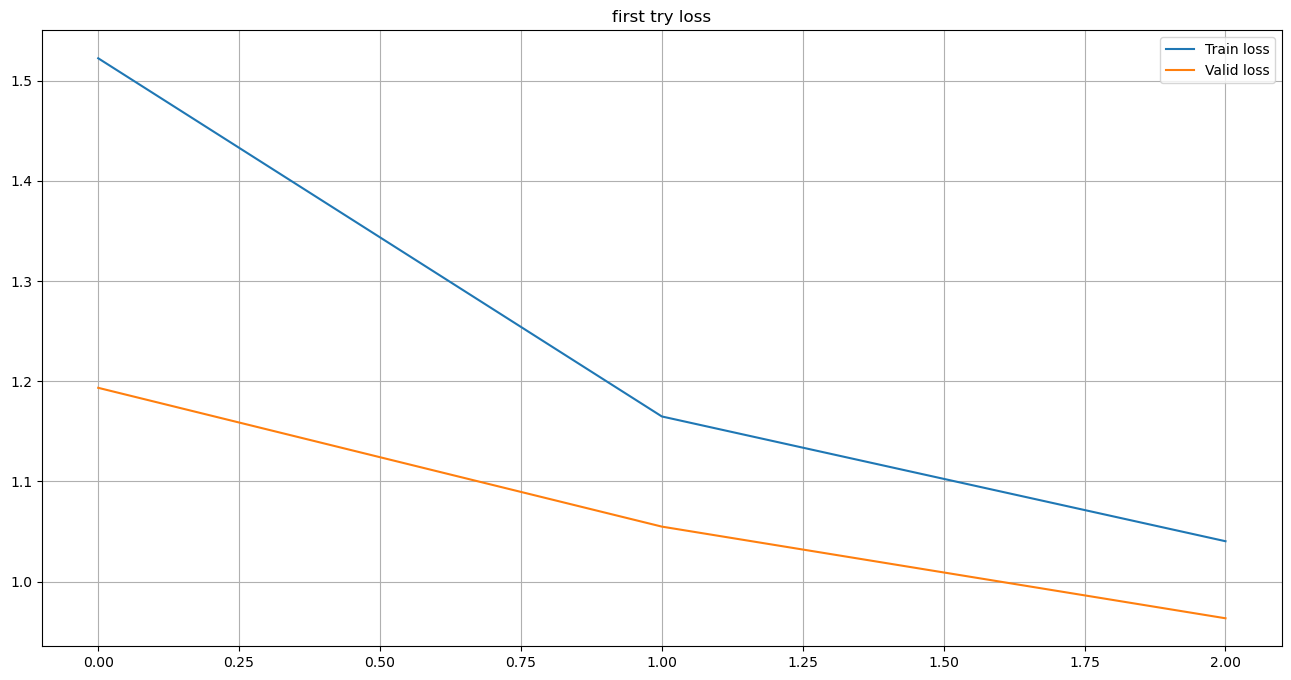

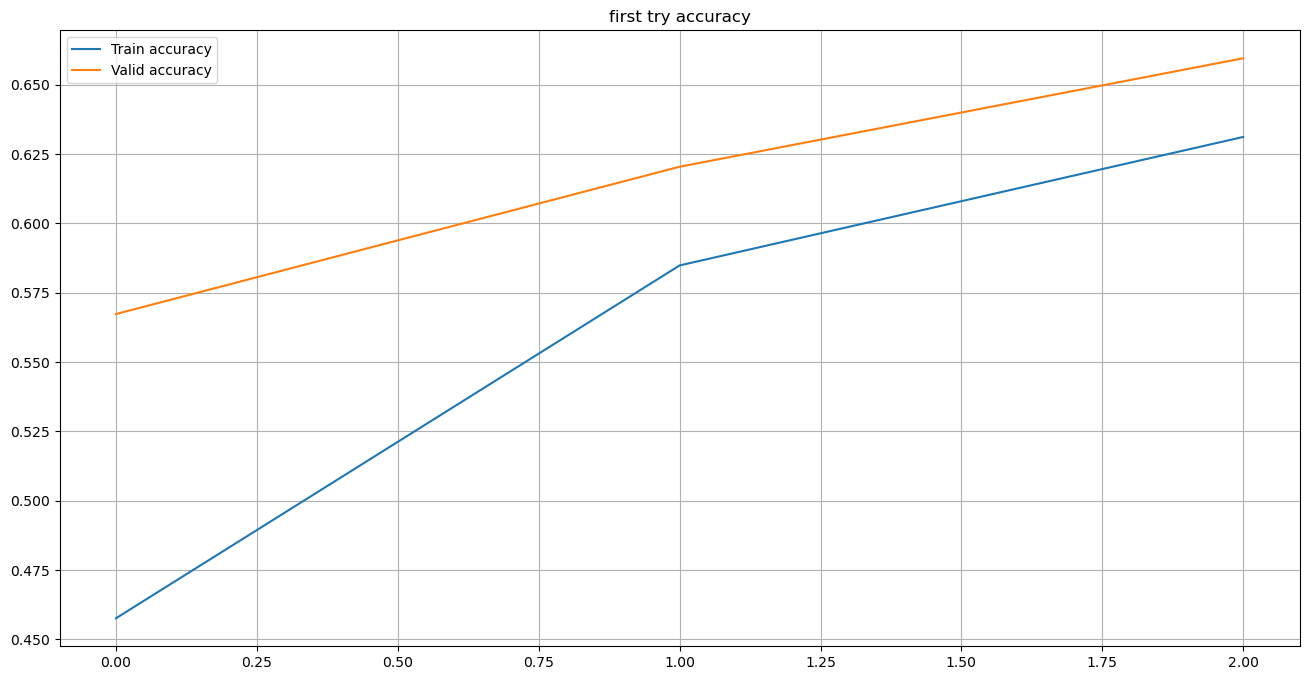

In [17]:
whole_train_valid_cycle_with_scheduler(model, 3, 'first try')

In [23]:
model_preds = predict(model, test_loader, device)
torch.save(model_preds, 'model_preds')

In [40]:
@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()
    
    prediction = []
    for i in range(iterations):
        single_prediction = []
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            output = model(x)
            single_prediction.append(output)
        prediction.append(torch.vstack(single_prediction))
            
    return torch.argmax(torch.stack((prediction)).data.mean(axis=0), 1)

In [34]:
model = create_advanced_conv_cifar()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = StepLR(optimizer, step_size=20)


In [35]:
model = model.to(device)

In [30]:
train_transforms = T.Compose(
    [
        T.RandomCrop(32, padding=4, padding_mode='reflect'), 
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

In [36]:
train_data = CIFAR10('../datasets/cifar10', train=True, transform=train_transforms)
test_data = CIFAR10('../datasets/cifar10', train=False, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True)

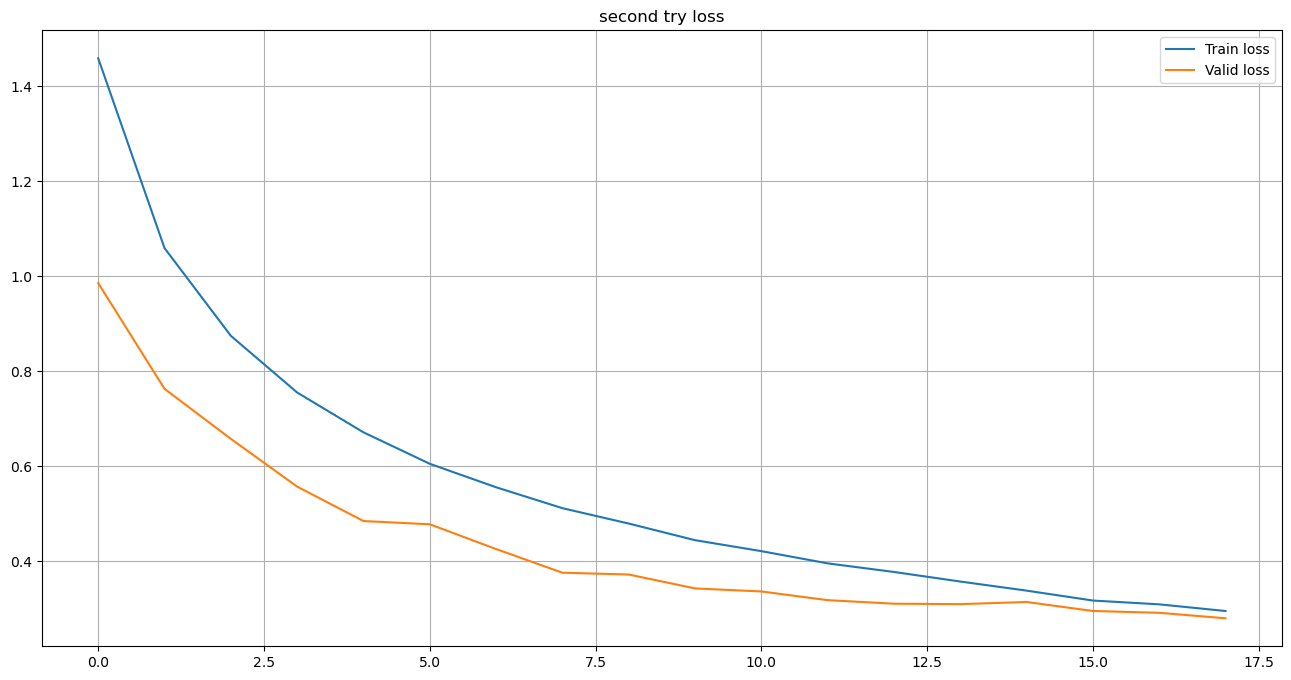

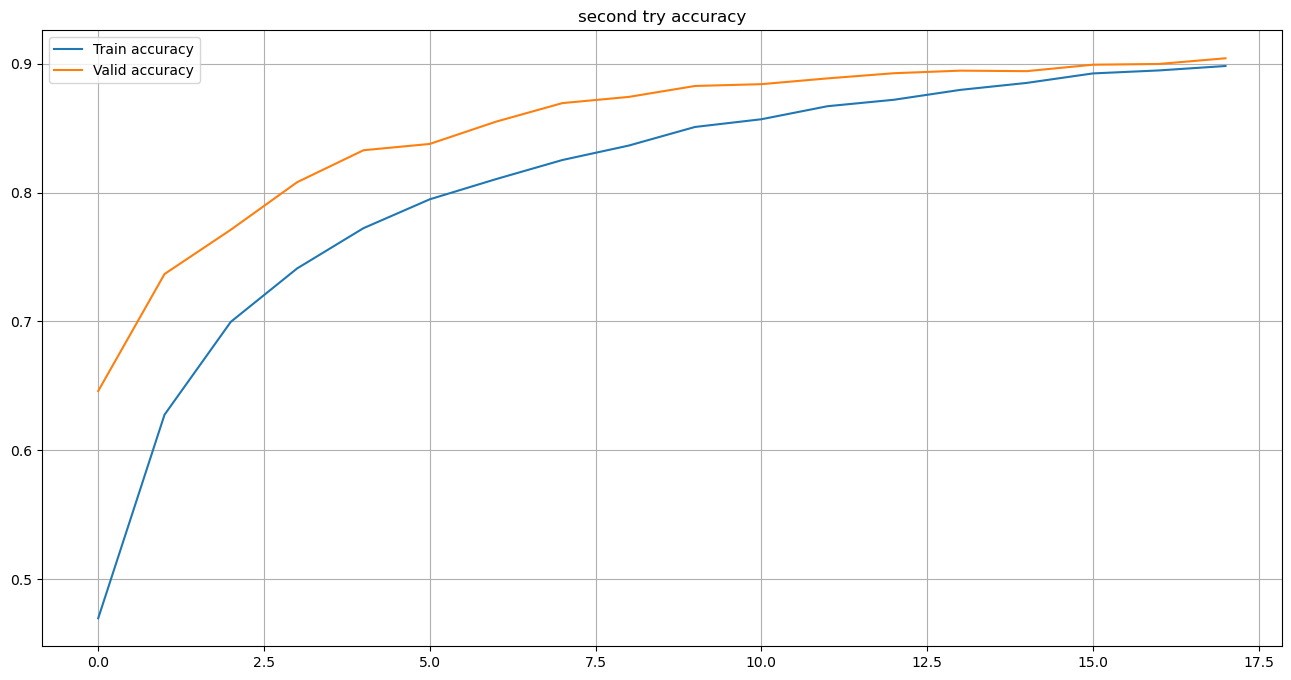

In [37]:
whole_train_valid_cycle_with_scheduler(model, 30, 'second try')

In [38]:
test_transforms_tta = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_data_tta = CIFAR10('../datasets/cifar10', train=False, transform=test_transforms_tta)

test_loader_tta = DataLoader(test_data_tta, batch_size=16, shuffle=False, pin_memory=True)

In [41]:
tta = predict_tta(model, test_loader_tta, device)

In [42]:
torch.save(tta, 'tensor2.pt')